In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "10_adv_problems/10d_conditonal_gan.ipynb"
_nb_title = "Conditional GANs"
_nb_message = """
Train a vanilla and a deep convolutional conditional GAN on MNIST.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Conditional+GANs&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F10_adv_problems%2F10d_conditonal_gan.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/10_adv_problems/10d_conditonal_gan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/10_adv_problems/10d_conditonal_gan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/10_adv_problems/10d_conditonal_gan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Conditional GANs</h1>
Train a vanilla and a deep convolutional conditional GAN on MNIST.


# Conditional Generative Adversarial Networks (cGANs)

## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.18.5


## Constants

In [21]:
IMAGE_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
LATENT_DIM = 512

## Vanilla GANs

For a vanilla GAN, we use just basic `Dense` layers for both the generator and discriminator.

In [46]:
# Create the generator.
def create_label_vectors(
    labels, num_classes, embedding_dim, dense_units
):
    """Creates label vectors from label indices.

    Args:
        labels: tensor, rank 1 tensor of labels with shape (batch_size,).
        num_classes: int, the number of image classes.
        embedding_dim: int, the embedding's output dimension.
        dense_units: int, the number of units for `Dense` layer.

    Returns:
        label_vectors: tensor, rank 2 tensor of shape
            (batch_size, dense_units).
    """
    embedded_labels = tf.keras.layers.Embedding(
        input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    label_vectors = tf.keras.layers.Dense(
        units=dense_units
    )(inputs=embedded_labels)

    return label_vectors

def standard_vanilla_generator(inputs, output_shape):
    """Returns output of standard vanilla generator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).
        output_shape: tuple, the shape of the output without batch dimension.

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = tf.keras.layers.Dense(units=64)(inputs=inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=128)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=256)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(
        units=output_shape[0] * output_shape[1] * output_shape[2],
        activation="tanh"
    )(inputs=x)

    outputs = tf.keras.layers.Reshape(target_shape=output_shape)(inputs=x)

    return outputs

def create_vanilla_generator(latent_dim, num_classes, output_shape):
    """Creates vanilla conditional GAN generator model.

    Args:
        latent_dim: int, the latent vector dimension length.
        num_classes: int, the number of image classes.
        output_shape: tuple, the shape of the output without batch dimension.

    Returns:
        Keras Functional Model.
    """
    latent_vector = tf.keras.Input(shape=(latent_dim,))

    labels = tf.keras.Input(shape=())
    label_vectors = create_label_vectors(
        labels, num_classes, embedding_dim=50, dense_units=50
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[latent_vector, label_vectors])
    
    outputs = standard_vanilla_generator(
        inputs=concatenated_inputs, output_shape=output_shape
    )

    return tf.keras.Model(
        inputs=[latent_vector, labels],
        outputs=outputs,
        name="vanilla_generator"
    )

vanilla_generator = create_vanilla_generator(
    latent_dim=LATENT_DIM, num_classes=NUM_CLASSES, output_shape=IMAGE_SHAPE
)
vanilla_generator.summary()

Model: "vanilla_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 50)           500         input_31[0][0]                   
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 50)           2550        embedding_14[0][0]               
__________________________________________________________________________________

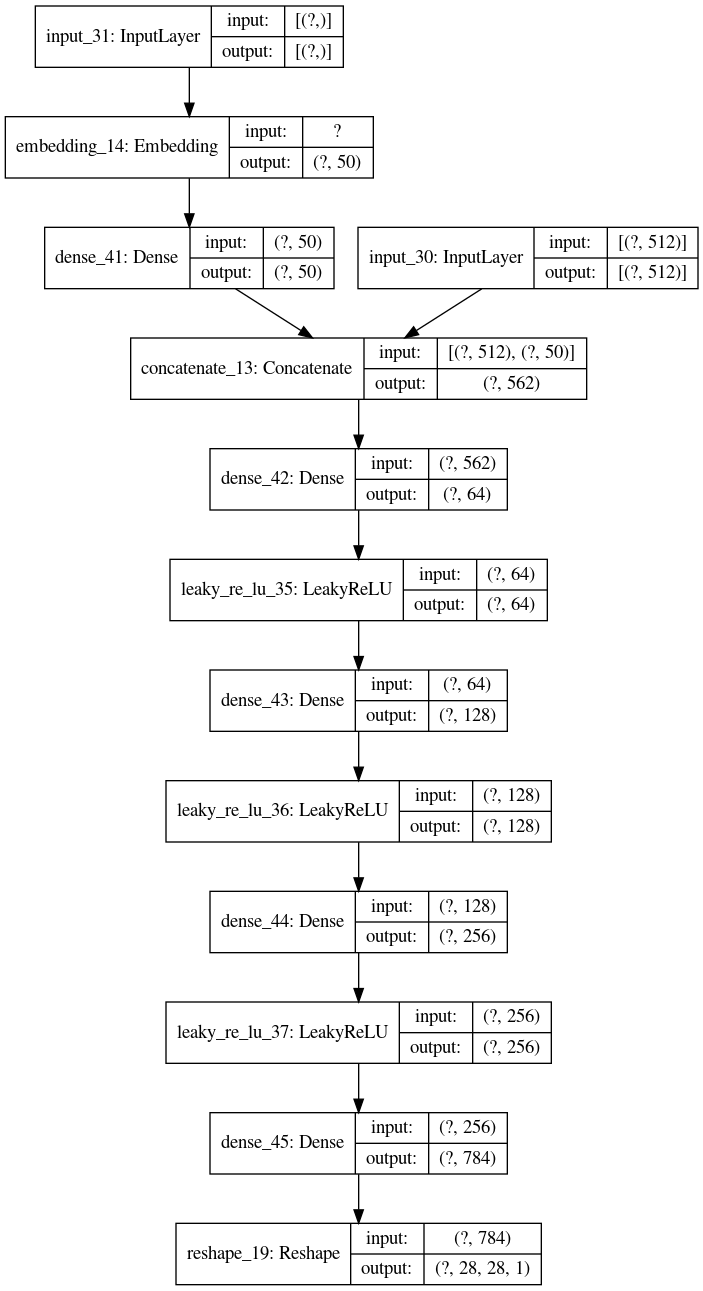

In [55]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=vanilla_generator,
    to_file="conditional_vanilla_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [48]:
# Create the discriminator.
def create_label_images(
    labels, num_classes, embedding_dim, image_shape
):
    """Creates label images from label indices.

    Args:
        labels: tensor, rank 1 tensor of labels with shape (batch_size,).
        num_classes: int, the number of image classes.
        embedding_dim: int, the embedding's output dimension.
        image_shape: tuple, the shape of the image without batch dimension.

    Returns:
        label_image: tensor, rank 4 tensor of shape
            (batch_size, height, width, 1).
    """
    embedded_labels = tf.keras.layers.Embedding(
        input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    num_pixels = image_shape[0] * image_shape[1]
    dense_labels = tf.keras.layers.Dense(
        units=num_pixels
    )(inputs=embedded_labels)
    label_image = tf.keras.layers.Reshape(
        target_shape=(image_shape[0], image_shape[1], 1)
    )(inputs=dense_labels)

    return label_image

def standard_vanilla_discriminator(inputs):
    """Returns output of standard vanilla discriminator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = tf.keras.layers.Flatten()(inputs=inputs)
    x = tf.keras.layers.Dense(units=256)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=128)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=64)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)

    outputs = tf.keras.layers.Dense(units=1)(inputs=x)

    return outputs

def create_vanilla_discriminator(image_shape, num_classes):
    """Creates vanilla conditional GAN discriminator model.

    Args:
        image_shape: tuple, the shape of the image without batch dimension.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    images = tf.keras.Input(shape=image_shape)

    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels, num_classes, embedding_dim=50, image_shape=image_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[images, label_image])

    outputs = standard_vanilla_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels],
        outputs=outputs,
        name="vanilla_discriminator"
    )

vanilla_discriminator = create_vanilla_discriminator(
    image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
)
vanilla_discriminator.summary()

Model: "vanilla_discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 50)           500         input_33[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 784)          39984       embedding_15[0][0]               
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________

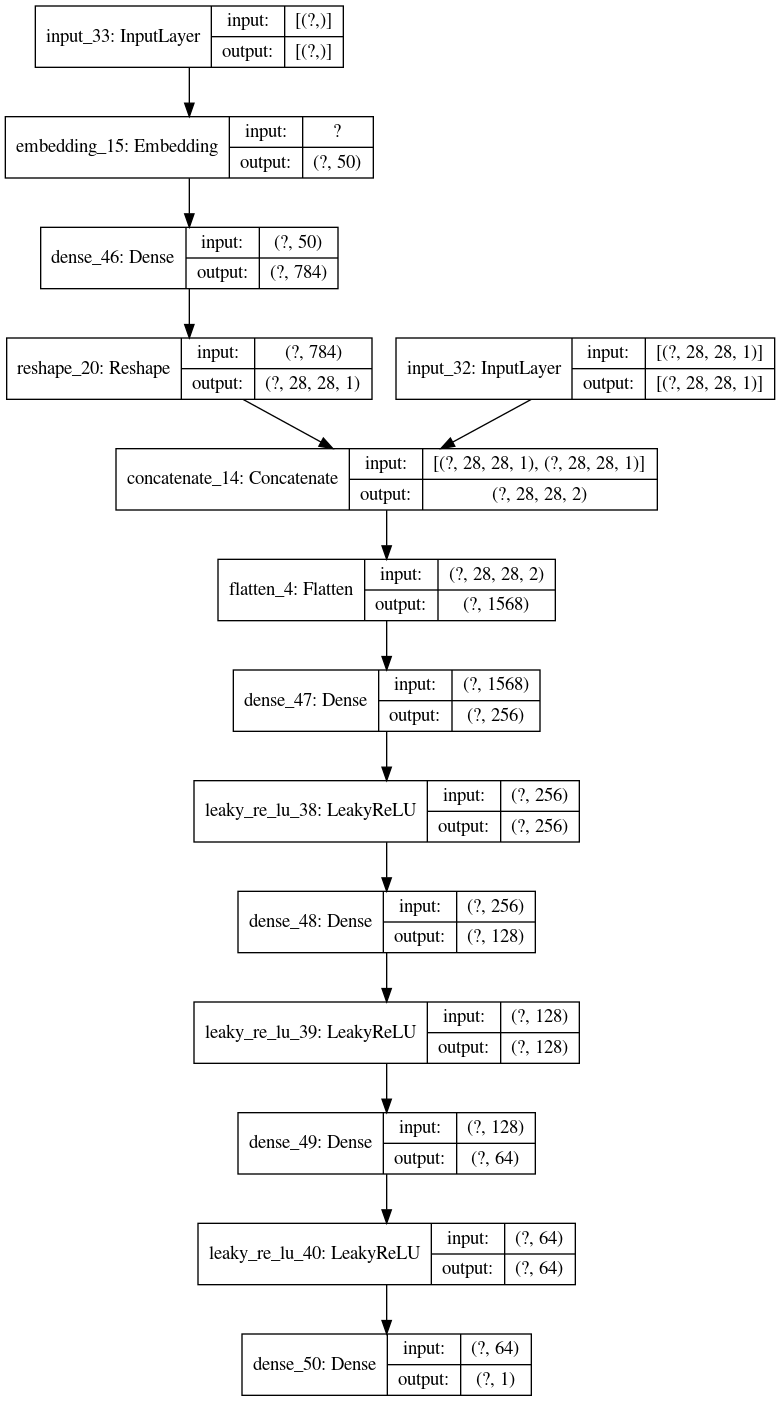

In [56]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=vanilla_discriminator,
    to_file="conditional_vanilla_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

We'll create a custom `Model` class named `GAN` that we can use to facilitate training of our generator and discriminator networks.

In [11]:
class GAN(tf.keras.Model):
    """Custom model for training a GAN.

    Attributes:
        discriminator: Keras `Model`, the discriminator network.
        generator: Keras `Model`, the generator network.
        latent_dim: int, the latent vector dimension length.
        one_sided_label_smoothing: float, how much to smooth the real image
            labels by value in [0., 1.].
        discriminator_optimizer: Keras `Optimizer`, optimizer for
            discriminator network.
        generator_optimizer: Keras `Optimizer`, optimizer for generator
            network.
        loss_fn: Keras `Loss`, loss function for training both networks.
    """
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """Instantiates `GAN` model class.

        Args:
            discriminator: Keras `Model`, the discriminator network.
            generator: Keras `Model`, the generator network.
            latent_dim: int, the latent vector dimension length.
            one_sided_label_smoothing: float, how much to smooth the real image
                labels by value in [0., 1.].
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        """Overrides base `Model` class' compile method.

        Args:
            discriminator_optimizer: Keras `Optimizer`, optimizer for
                discriminator network.
            generator_optimizer: Keras `Optimizer`, optimizer for generator
                network.
            loss_fn: Keras `Loss`, loss function for training both networks.
        """
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images, input_labels):
        """Trains discriminator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).
            input_labels: tensor, rank 1 tensor of labels with shape (batch_size,).

        Returns:
            discriminator_loss: tensor, scalar loss of disriminator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Generate images from noise.
        generated_images = self.generator(
            inputs=[random_latent_vectors, input_labels]
        )

        # Combine generated images with real images.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # Create fake and real labels.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # Smooth real labels to help with training.
        real_labels *= self.one_sided_label_smoothing

        # Combine labels to be in-line with combined images.
        labels = tf.concat(
            values=[fake_labels, real_labels], axis=0
        )

        # Train ONLY the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=[
                    combined_images,
                    tf.concat(values=[input_labels, input_labels], axis=0)
                ]
            )
            discriminator_loss = self.loss_fn(
                y_true=labels, y_pred=predictions
            )

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size, input_labels):
        """Trains generator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            input_labels: tensor, rank 1 tensor of labels with shape (batch_size,).

        Returns:
            generator_loss: tensor, scalar loss of generator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Create labels as if they're real images.
        labels = tf.ones(shape=(batch_size, 1))

        # Train ONLY the generator.
        with tf.GradientTape() as tape:
            fake_images = self.generator(
                inputs=[random_latent_vectors, input_labels]
            )
            predictions = self.discriminator(
                inputs=[fake_images, input_labels]
            )
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, features):
        """Trains `GAN` for one step.

        Args:
            features: dict, images key has rank 4 tensor of real images with
                shape (batch_size, height, width, depth) for value and labels
                key has rank 1 tensor of labels with shape (batch_size,).

        Returns:
            losses: dict, dictionary of losses from each sub-training step.
        """
        real_images = features["images"]
        input_labels = features["labels"]

        # Get dynamic batch size to use for random noise vectors.
        batch_size = tf.shape(input=real_images)[0]

        # First train discriminator.
        discriminator_loss = self.discriminator_train_step(
            batch_size, real_images, input_labels
        )

        # Then train generator.
        generator_loss = self.generator_train_step(
            batch_size, input_labels
        )

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss
        }

        return losses


In [12]:
def create_train_dataset(batch_size):
    """Creates training dataset.

    Args:
        batch_size: int, number of elements in a mini-batch.

    Returns:
        dataset: `Dataset`, dataset object for training using MNIST.
    """
    # Get and format MNIST data.
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Let's combine both training and test sets.
    combined_images = np.concatenate([x_train, x_test])
    combined_images = (combined_images.astype("float32") - 127.5) / 255.0
    combined_images = np.reshape(combined_images, newshape=(-1, 28, 28, 1))

    combined_labels = np.concatenate([y_train, y_test])

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(
        tensors={"images": combined_images, "labels": combined_labels}
    )
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size)

    return dataset


In [43]:
# Instantiate a GAN instance using our vanilla generator and discriminator.
vanilla_gan = GAN(
    discriminator=vanilla_discriminator,
    generator=vanilla_generator,
    latent_dim=LATENT_DIM,
    one_sided_label_smoothing=0.9
)

vanilla_gan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# Train vanilla GAN model.
vanilla_gan_history = vanilla_gan.fit(
    create_train_dataset(batch_size=128), epochs=30
)

Epoch 1/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5864 - generator_loss: 1.5588
Epoch 2/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5405 - generator_loss: 1.6450
Epoch 3/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5458 - generator_loss: 1.4979
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5774 - generator_loss: 1.4053
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5725 - generator_loss: 1.3950
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5857 - generator_loss: 1.3824
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5872 - generator_loss: 1.3889
Epoch 8/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.5902 - generator_loss: 1.3739
Epoch 9/30
547/547 [====================

Let's plot the loss history and some generated images using our trained model.

In [14]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()


In [15]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

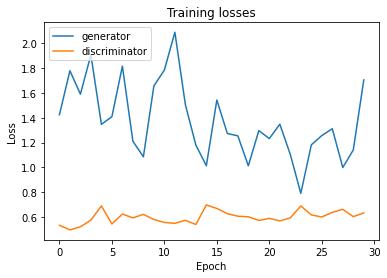

In [16]:
plot_loss_history(history=vanilla_gan_history)

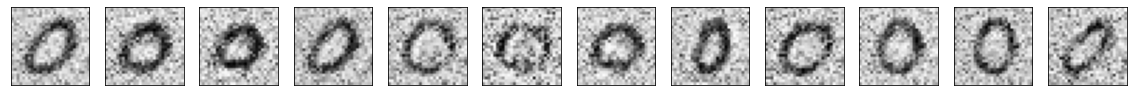

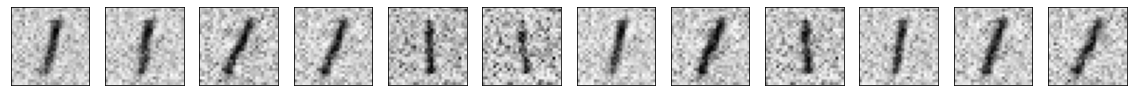

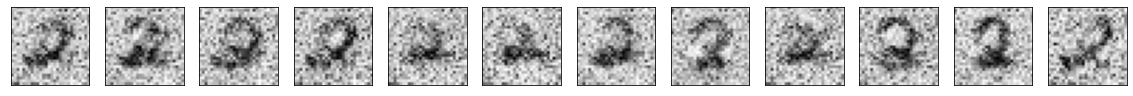

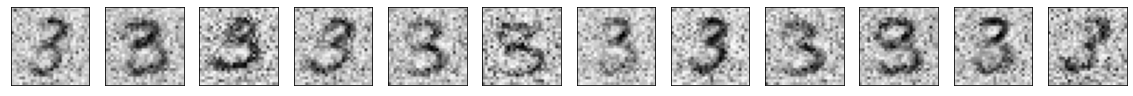

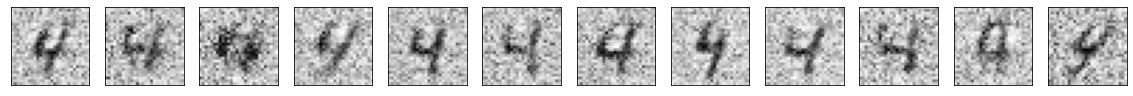

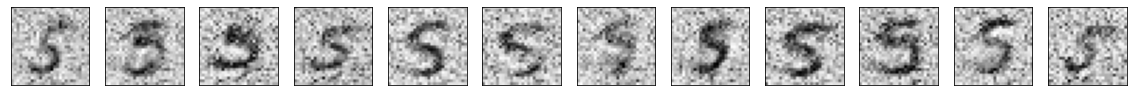

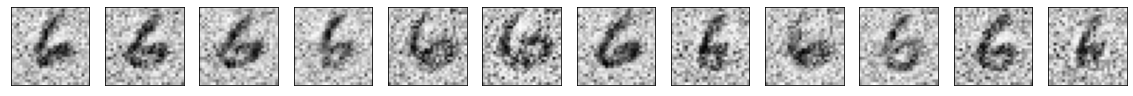

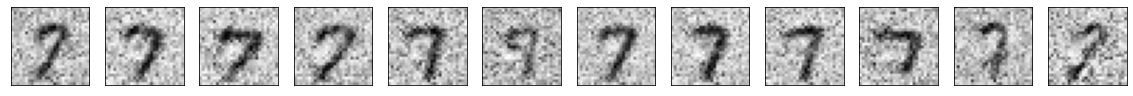

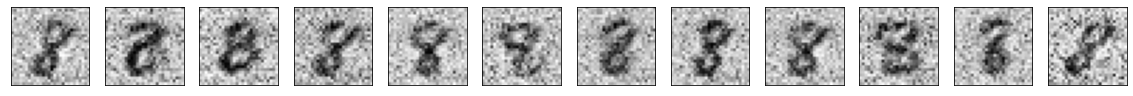

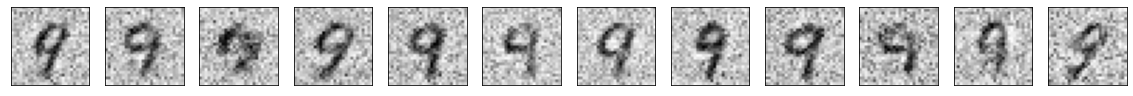

In [19]:
num_examples = 12
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(
        images=vanilla_gan.generator(
            inputs=[latent_vectors, labels]
        )
    )

## DCGAN

A Deep-convolutional GAN (DCGAN) uses convolutional (`Conv2D`) and deconvolutional (`Conv2DTranspose`) instead of `Dense` layers for the discriminator and generator respectively.

In [50]:
# Create the generator
def project_latent_vector(latent_vector, projection_shape):
    """Projects latent vector into an image.

    Args:
        latent_vector: tensor, rank 2 tensor of labels with shape
            (batch_size, latent_dim).
        projection_shape: 3-tuple, the shape to project vector into an image.

    Returns:
        latent_image: tensor, rank 4 tensor of shape
            (
                batch_size,
                projection_shape[0],
                projection_shape[1],
                projection_shape[2]
            ).
    """
    projected_latents = tf.keras.layers.Dense(
        units=projection_shape[0] * projection_shape[1] * projection_shape[2]
    )(inputs=latent_vector)
    projected_latents = tf.keras.layers.LeakyReLU(
        alpha=0.2
    )(inputs=projected_latents)
    latent_image = tf.keras.layers.Reshape(
        target_shape=projection_shape
    )(inputs=projected_latents)

    return latent_image

def create_generator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """Creates generator block of layers.

    Args:
        inputs: tensor, rank 4 image tensor of shape
            (batch_size, height, width, channels).
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        outputs: tensor, rank 4 image tensor of shape
            (batch_size, height * 2, width * 2, filters).
    """
    x = tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

def standard_DCGAN_generator(inputs):
    """Returns output of standard DCGAN generator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = create_generator_block(
        inputs=inputs,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_generator_block(
        inputs=x,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2
    )

    outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding="same", activation="tanh"
    )(inputs=x)

    return outputs

def create_dcgan_generator(latent_dim, num_classes):
    """Creates deep convolutional conditional GAN generator model.

    Args:
        latent_dim: int, the latent vector dimension length.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    projection_shape = (7, 7, 256)

    latent_vector = tf.keras.Input(shape=(latent_dim,))
    latent_image = project_latent_vector(latent_vector, projection_shape)
    
    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=projection_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[latent_image, label_image])

    outputs = standard_DCGAN_generator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[latent_vector, labels],
        outputs=outputs,
        name="dcgan_generator"
    )

dcgan_generator = create_dcgan_generator(
    latent_dim=LATENT_DIM, num_classes=NUM_CLASSES
)
dcgan_generator.summary()

Model: "dcgan_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 12544)        6435072     input_34[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 50)           500         input_35[0][0]                   
____________________________________________________________________________________

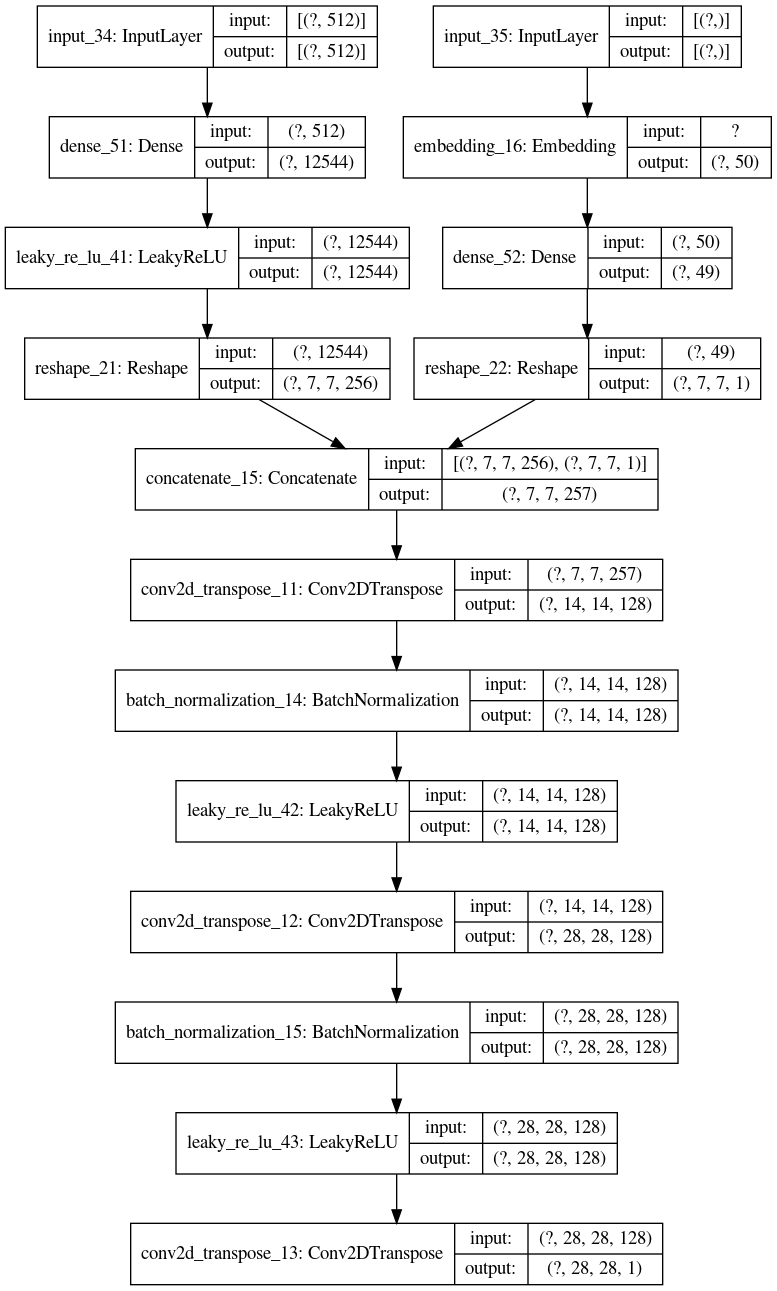

In [57]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_generator,
    to_file="conditional_dcgan_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [53]:
# Create the discriminator
def create_discriminator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """Creates discriminator block of layers.

    Args:
        inputs: tensor, rank 4 image tensor of shape
            (batch_size, height, width, channels).
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        outputs: tensor, rank 4 image tensor of shape
            (batch_size, height // 2, width // 2, filters).
    """
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

def standard_DCGAN_discriminator(inputs):
    """Returns output of standard DCGAN discriminator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 2 tensor of shape (batch_size, 1).
    """
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=1, padding="same"
    )(inputs=inputs)

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_discriminator_block(
        inputs=x,
        filters=256,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = tf.keras.layers.Flatten()(inputs=x)
    outputs = tf.keras.layers.Dense(units=1)(inputs=x)

    return outputs

def create_dcgan_discriminator(image_shape, num_classes):
    """Creates deep convolutional conditional GAN discriminator model.

    Args:
        image_shape: tuple, the shape of the image without batch dimension.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    images = tf.keras.Input(shape=image_shape)

    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=image_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[images, label_image])

    outputs = standard_DCGAN_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels],
        outputs=outputs,
        name="dcgan_discriminator"
    )

dcgan_discriminator = create_dcgan_discriminator(
    image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
)
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 50)           500         input_39[0][0]                   
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 784)          39984       embedding_18[0][0]               
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 28, 28, 1)]  0                                            
________________________________________________________________________________

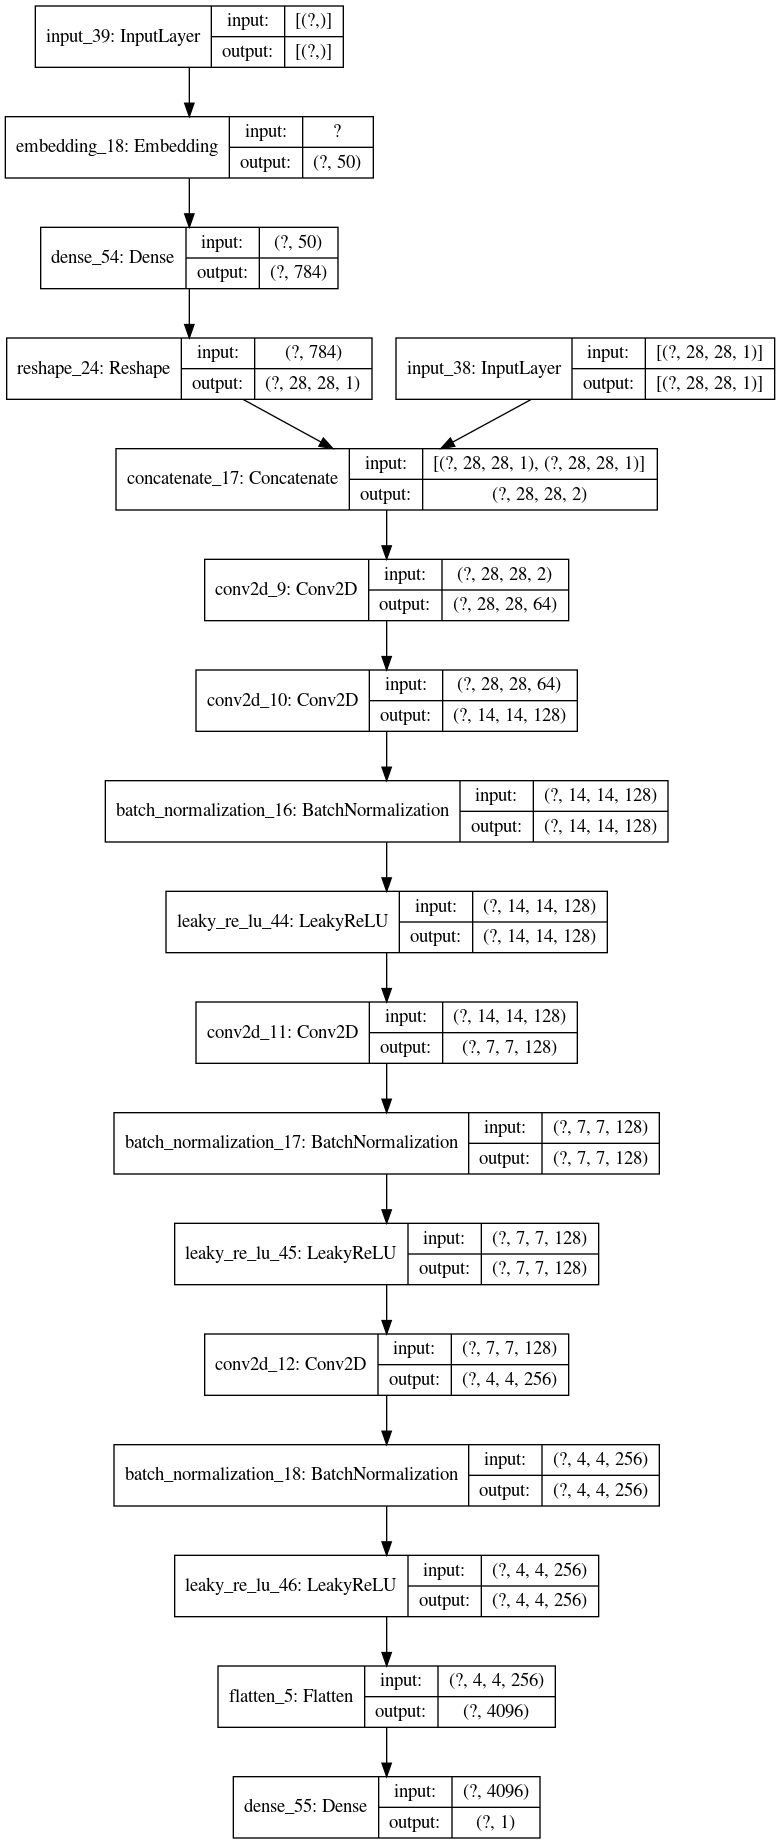

In [58]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_discriminator,
    to_file="conditional_dcgan_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [34]:
# Instantiate a GAN instance using our DCGAN generator and discriminator.
dcgan = GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=LATENT_DIM,
    one_sided_label_smoothing=0.9
)

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# Train DCGAN model.
dcgan_history = dcgan.fit(create_train_dataset(batch_size=128), epochs=50)

Epoch 1/50
547/547 [==============================] - 43s 79ms/step - discriminator_loss: 0.5787 - generator_loss: 1.1884
Epoch 2/50
547/547 [==============================] - 42s 76ms/step - discriminator_loss: 0.5155 - generator_loss: 1.4571
Epoch 3/50
547/547 [==============================] - 42s 77ms/step - discriminator_loss: 0.4319 - generator_loss: 1.8874
Epoch 4/50
547/547 [==============================] - 42s 77ms/step - discriminator_loss: 0.4789 - generator_loss: 1.6884
Epoch 5/50
547/547 [==============================] - 42s 77ms/step - discriminator_loss: 0.4896 - generator_loss: 1.5933
Epoch 6/50
547/547 [==============================] - 42s 77ms/step - discriminator_loss: 0.4921 - generator_loss: 1.6015
Epoch 7/50
547/547 [==============================] - 42s 77ms/step - discriminator_loss: 0.4935 - generator_loss: 1.6060
Epoch 8/50
547/547 [==============================] - 42s 77ms/step - discriminator_loss: 0.4924 - generator_loss: 1.6095
Epoch 9/50
547/547 [====

Let's plot the loss history and some generated images using our trained model.

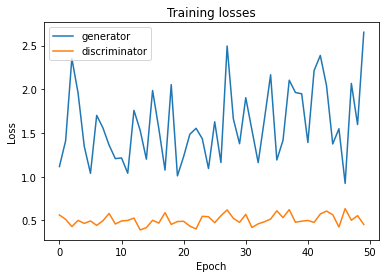

In [35]:
plot_loss_history(history=dcgan_history)

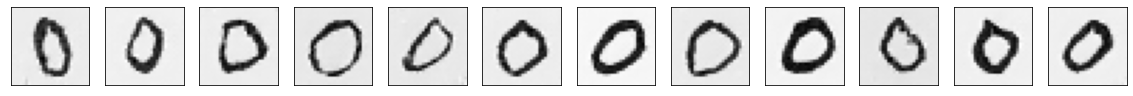

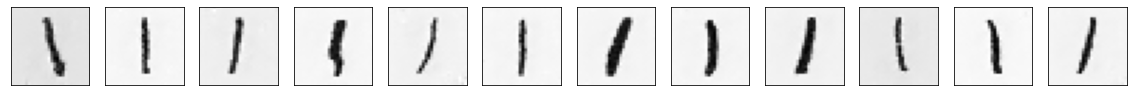

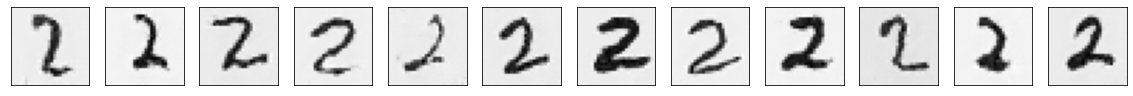

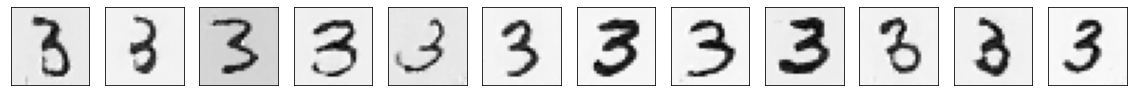

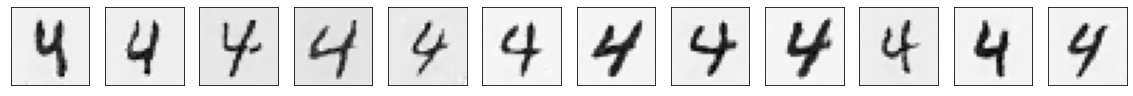

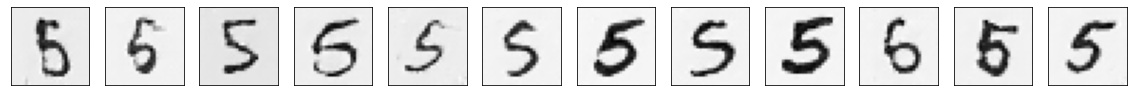

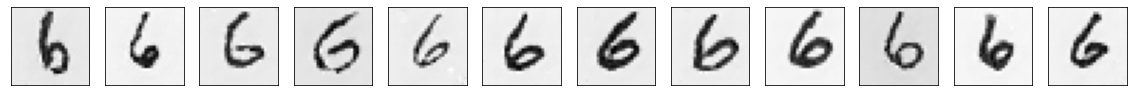

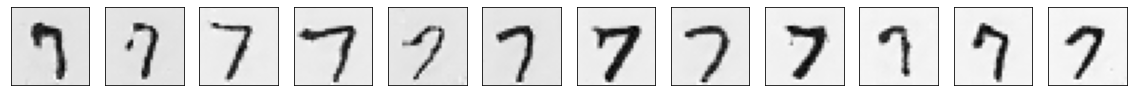

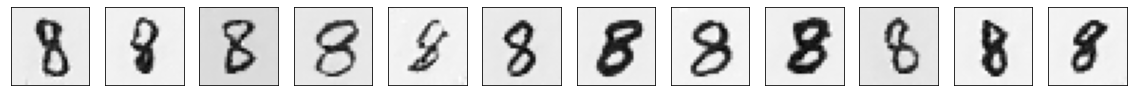

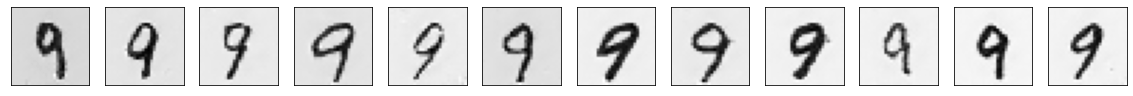

In [36]:
num_examples = 12
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(
        images=dcgan.generator(
            inputs=[latent_vectors, labels]
        )
    )